## Sun Prediction using the AOPP weather station and MODIS


In this lab, you will create a simple machine learning model to predict how sunny it will be in Oxford in the afternoon using [AOPP weather station measurements](https://weatherstationdata.physics.ox.ac.uk) and [MODIS-Terra](https://modis.gsfc.nasa.gov/about/) images. Since 2012, the AOPP weather station measures the average wind, temperature, pressure, and humidity over the last ten seconds, every ten seconds. Terra is a sun-synchronous satellite that observes the Earth during the morning (local time), and acquires global coverage every 1-2 days. The MODIS instrument takes images in [36 spectral bands](https://modis.gsfc.nasa.gov/about/specifications.php).

### 1. Objectives
The goals of this lab are to:

1. Familiarize yourself with weather station observations and MODIS satellite data
2. Visualize time series of weather station data and sample MODIS images
3. Train a simple baseline model to get to know the prediction task.
4. Create a supervised machine learning pipeline using Pytorch Lightning and develop
    - dataloaders
    - data augmentations & transformations
    - (one or more) machine learning models
    - validation metrics
5. Explore interpretability, predictability, & model improvements

Throughout the lab, you'll find skeleton implementations containing `...` in places that need filling in to carry out the experiments.

#### 1.1. ML Task
We are trying to predict **how much sun we should expect in the afternoon (between 13:00 and 20:59)**, based on how sunny the previous 3 afternoons have been (plus other weather station measurements from the past 3 days), as well as a satellite image from the morning (around 11am) of the same day.

### 2. Data Exploration
First, let's explore the two datasets that you will work with. We are using weather station measurements and MODIS observations from 2016 to 2021.

#### 2.1. Weather Station

The observations have been pre-processed for this lab, to create a dataset with one entry for each day. Each row in the processed dataset contains:

Name | Description | Unit
--- | --- | --- |
date | | yyyy-mm-dd
total_sun_per_day | the total amount of sunshine | hours of sunshine
mean_wind_per_day | the average wind speed | metres per second
mean_wind_direction_per_day | the average direction of the wind | degrees
mean_temperature_per_day | the average temperature | degrees Celsius
total_rain_per_day | the total amount of rain | millimetres
mean_pressure_per_day | the average pressure | hectopascal
total_sun_1to8pm | the amount of sunshine between 13:00 and 20:59pm | hours of sunshine (0 to 8)
mean_wind_direction_9to10am | the average direction of the wind between 9 and 10am | degrees 
mean_wind_9to10am | the average wind speed between 9 and 10am | metres per second
mean_humidity_9to10am | the average relative humidty between 9 and 10am | percent
mean_pressure_9to10am | the average pressure between 9 and 10am | hectopascal

In [1]:
import pathlib

DATA_PATH = pathlib.Path('/gws/nopw/j04/iecdt/ai4eo/data/1-sunny-oxford/')
if DATA_PATH.exists():
    print("Storing data on JASMIN")
else:
    DATA_PATH = pathlib.Path("../../data/1-sunny-oxford")
    print("Storing data locally")
    if not DATA_PATH.exists():
        DATA_PATH.mkdir()

Storing data on JASMIN


In [2]:
import pandas as pd
import glob
station_paths = glob.glob('../data/1-sunny-oxford/weatherstation/*')
station_dfs = [pd.read_csv(station_path) for station_path in station_paths]

weather_station = pd.concat(station_dfs, ignore_index=True).sort_values(by='date').reset_index(drop=True)
weather_station['date'] = pd.to_datetime(weather_station['date'])

weather_station.head()

,date,total_sun_per_day,mean_wind_per_day,mean_wind_direction_per_day,mean_temperature_per_day,total_rain_per_day,mean_pressure_per_day,total_sun_3to4pm,total_sun_1to8pm,mean_wind_direction_9to10am,mean_wind_9to10am,mean_humidity_9to10am,mean_pressure_9to10am
0,2016-01-01,0.00,1.917347,105.357999,4.385523,0.13,1011.496888,0.00,0.00,94.646409,3.881215,80.289503,1009.046961
1,2016-01-02,0.00,2.033233,136.636311,8.110790,5.10,995.416945,0.00,0.00,97.831025,0.025762,90.551247,992.493075
2,2016-01-03,0.04,1.185788,145.140272,5.843534,8.19,989.301982,0.04,0.04,105.270718,0.274862,88.554144,983.138122
3,2016-01-04,0.37,0.279214,134.079157,5.778557,3.46,981.861044,0.00,0.06,125.381215,0.011326,88.483978,981.842541
4,2016-01-05,0.09,0.066878,129.886445,6.027145,1.02,984.316020,0.06,0.06,137.726519,0.015470,87.608840,985.000000


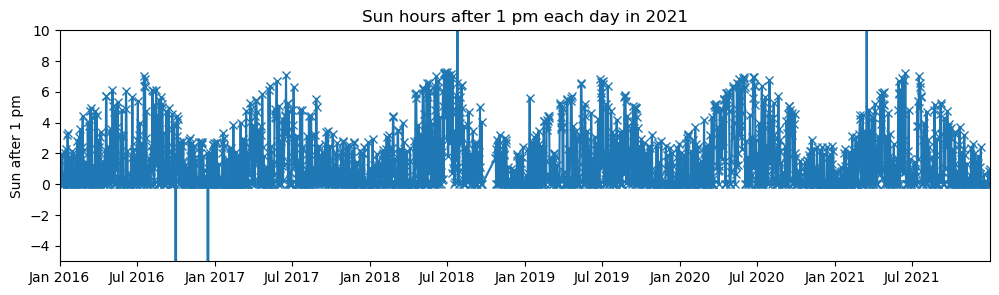

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 3))

# plot daily sun hours
plt.plot(weather_station['date'], weather_station['total_sun_1to8pm'], '-x')
plt.title('Sun hours after 1 pm each day in 2021')
plt.ylabel('Sun after 1 pm')

plt.xlim(weather_station['date'].min(), weather_station['date'].max())
plt.ylim(-5, 10)

# set xticks and xlabels to every 6 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.show()

Missing values in measurements are denoted by `-999` - this can create very large negative numbers if a sensor takes invalid measurements for a period of time when summed over each day. We also know that there is a strict upper bound for the amount of sunshine hours that can be measured between 1pm and 8:59pm. We therefore remove invalid measurements for our experiments.

**Question:** Based on our knowledge about the data, what would be sensible lower and upper bounds on our measurements? Fill in the values below and look at the new timeseries.

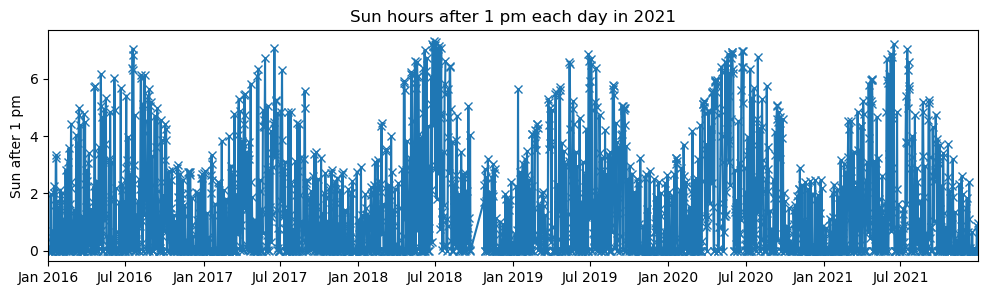

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

plt.figure(figsize=(12, 3))

sun_data = weather_station['total_sun_1to8pm'].to_numpy()
sun_data[(sun_data > 8) | (sun_data < 0)] = np.nan # TODO: replace ... with a lower and upper bound

dates = weather_station['date'].to_numpy()

# plot daily sun hours
plt.plot(weather_station['date'], sun_data, '-x')
plt.title('Sun hours after 1 pm each day in 2021')
plt.ylabel('Sun after 1 pm')

plt.xlim(dates[0], dates[-1])

# set xticks and xlabels to every 6 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.show()

**Question:** What do you notice about our dataset? Which aspects might affect machine learning models that are trained to predict sun throughout the year?

One common way to study timeseries is to compute the Autocorrelation timescale. It refers to the amount of time over which the values in the dataset are correlated. 

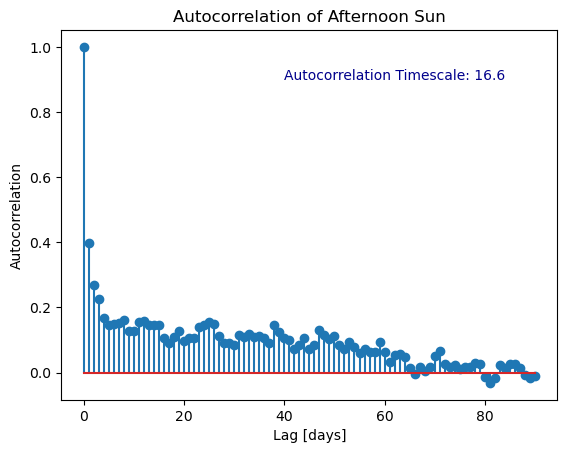

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

sun_data_nonan = sun_data[~np.isnan(sun_data)]

# compute the autocorrelation function
lags = 90  # Number of lags to compute
acf_values = acf(sun_data_nonan, nlags=lags, fft=True)

# estimate autocorrelation timescale
autocorrelation_timescale = 1 + 2 * np.sum(acf_values[1:]) 

plt.stem(range(len(acf_values)), acf_values)
plt.xlabel("Lag [days]")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Afternoon Sun")
plt.text(40, 0.9, f"Autocorrelation Timescale: {autocorrelation_timescale:.1f}", color='darkblue')
plt.show()

Autocorrelation timescale measures how long the effect of a particular value persists in the time series before the series "forgets" it and becomes statistically independent. For an autocorrelation timescale of 17 days, this means the value of the dataset at a given time provides you with information to predict future values up to the next ~17 days.

**Question:** How is this relevant to our prediction task? Thinking of the task at hand, can you think of any 'slow' weather / climate processes that explain such long memory in our timeseries?

#### 2.2. MODIS Images
You can download MODIS data directly from NASA's [EarthData](https://earthdata.nasa.gov) platform using the python package `earthaccess` (https://earthaccess.readthedocs.io/) as shown in the example below. After downloading, a variety of processing steps are required to get your satellite dataset machine learning-ready. For example, filtering out invalid or incomplete observations, remapping images onto a common grid, normalising each spectral channel, patching your dataset, etc.

For the purpose of this lab, we already downloaded and prepared a small MODIS dataset. Run the cells below to explore the data format and visualise what the images look like.

_______________
Example earthaccess download script:

```python
import earthaccess
auth_obj  = earthaccess.login('interactive')

results = earthaccess.search_data(
    # MOD = Terra, 02 = Level1B Radiances, 1KM  resolution (all 36 spectral bands)
    short_name= 'MOD021KM', 
    # (lon min, lat min, lon max, lat max) - Oxford: 51.75° N, 1.26° W
    bounding_box=(0.5, 51, 1.5, 52), 
    temporal=('2021-01-01', '2021-01-05'),
)

files = earthaccess.download(results, local_path='./')
```

In [6]:
import xarray as xr
import tempfile
import urllib
import zipfile

MODIS_IMAGE_DIR = DATA_PATH/'modis'
modis_image_files = sorted(list(MODIS_IMAGE_DIR.glob("*.nc")))

# Download and extract if missing
if len(modis_image_files) == 0:
    with tempfile.NamedTemporaryFile() as tmp:
        print("Downloading https://zenodo.org/records/14203536/files/modis.zip")
        urllib.request.urlretrieve(
            "https://zenodo.org/records/14203536/files/modis.zip", tmp.name
        )
        print("Extracting modis.zip")
        with zipfile.ZipFile(tmp, 'r') as zip_ref:
            zip_ref.extractall(DATA_PATH)
    
    modis_image_files = sorted(list(MODIS_IMAGE_DIR.glob("*.nc")))

    assert len(modis_image_files), "Download failed!"


In [7]:
sample_ds = xr.load_dataset(modis_image_files[0])
sample_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 300, x: 300)
Coordinates:
  * y        (y) float64 2kB 52.99 52.98 52.97 52.96 ... 50.03 50.02 50.02 50.0
  * x        (x) float64 2kB -2.495 -2.485 -2.475 -2.465 ... 0.475 0.485 0.495
Data variables:
    1        (y, x) float32 360kB 9.304 9.304 8.067 7.195 ... 9.191 11.32 11.32
    3        (y, x) float32 360kB 11.74 11.74 10.97 10.47 ... 11.78 13.67 13.67
    4        (y, x) float32 360kB 9.492 9.492 8.47 7.771 ... 9.569 11.54 11.54
    5        (y, x) float32 360kB 10.87 10.87 8.998 8.935 ... 9.751 12.08 12.08
    2        (y, x) float32 360kB 11.73 11.73 9.859 8.66 ... 10.1 12.69 12.69
Attributes: (12/15)
    resolution:           1000
    calibration:          reflectance
    platform_name:        EOS-Terra
    file_type:            hdf_eos_data_1000m
    end_time:             2016-01-02 10:55:00
    units:                %
    ...                   ...
    rows_per_scan:        10
    ancillary_variables:  []
    modifiers:            []
    reader:               modis_l1b
    standard_name:        toa_bidirectional_reflectance
    start_time:           2016-01-02 10:50:00

MODIS is a multi-spectral satellite: it takes 36 images of each scene in 36 different wavelength channels. As you can see in the `Data variables`, MODIS channels 1 to 5 were processed. Their specifications are shown in the table below.

![MODIS bands](../challenges/1-sunny-oxford/images/modis_bands.png)


When plotting such multi-spectral observations we can either plot a single channel (first example below) or create so-called RGB-composites (second example). RGB composites assign 3 channels to each of red, blue and green, and colour each pixel in the image based on the measurement values of the three channels in that pixel. 

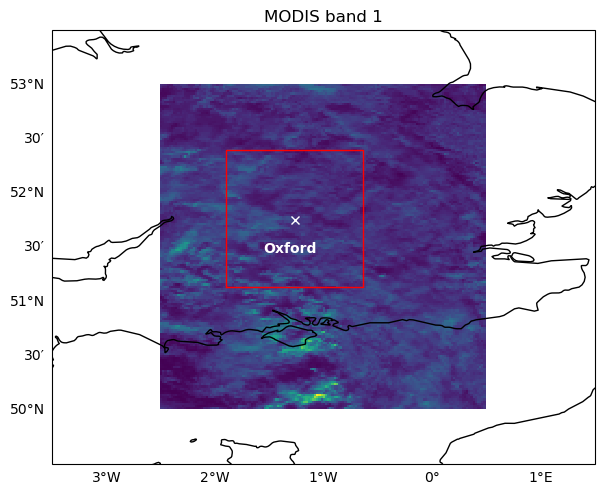

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

def plot_single_channel(ds, channel='1'):
    data = ds[channel]
    patch = data.isel(x=slice(60,188,2), y=slice(60,188,2))
    
    projection = ccrs.PlateCarree()
    
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    
    data.isel(x=slice(None,None,2), y=slice(None,None,2)).plot(ax=ax, transform=projection, cmap='viridis', add_colorbar=False)
    ax.coastlines()
    ax.set_extent([-3.5, 1.5, 49.5, 53.5], crs=projection)
    
    
    # add gridlines for reference
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0)
    gl.top_labels = False
    gl.right_labels = False
    
    # add marker for Oxford
    oxford_lon, oxford_lat = -1.2577, 51.7520
    ax.plot(oxford_lon, oxford_lat, marker='x', color='white', markersize=6, label="Oxford", transform=projection)
    ax.text(oxford_lon-0.3, oxford_lat-0.3, 'Oxford', color='white', weight='bold', fontsize=10)
    
    # draw a rectangle around the area we are interested in
    lons = [patch.x.min(), patch.x.max(), patch.x.max(), patch.x.min(), patch.x.min()]
    lats = [patch.y.min(), patch.y.min(), patch.y.max(), patch.y.max(), patch.y.min()]
    ax.plot(lons, lats, color='red', linewidth=1, transform=projection)
    
    plt.title(f"MODIS band {data.name}")
    plt.show()

plot_single_channel(sample_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


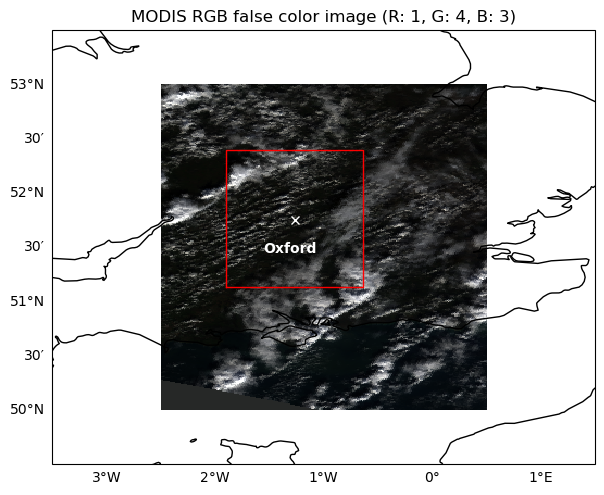

In [9]:
import numpy as np

def plot_rgb_false_color(ds):
    def normalize(band, scaling_factor=1.3):
        return (band - band.min()) / (band.max() - band.min()) * scaling_factor

    patch = ds['1'].isel(x=slice(60,188,2), y=slice(60,188,2))
    
    rgb_bands = ['1', '4', '3']
    
    rgb = [ds[var] for var in rgb_bands]
    rgb = [da.fillna(np.nanmean(da)) for da in rgb]
    rgb = [normalize(da) for da in rgb]
    rgb = xr.concat(rgb, dim='band').transpose('y', 'x', 'band')

    projection = ccrs.PlateCarree()

    # plot the RGB false color image
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})
    rgb.plot.imshow(ax=ax)
    ax.coastlines()
    ax.set_extent([-3.5, 1.5, 49.5, 53.5], crs=projection)
    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # add marker for Oxford
    oxford_lon, oxford_lat = -1.2577, 51.7520
    ax.plot(oxford_lon, oxford_lat, marker='x', color='white', markersize=6, label="Oxford", transform=projection)
    ax.text(oxford_lon-0.3, oxford_lat-0.3, 'Oxford', color='white', weight='bold', fontsize=10)
    
    # draw a rectangle around the area we are interested in
    lons = [patch.x.min(), patch.x.max(), patch.x.max(), patch.x.min(), patch.x.min()]
    lats = [patch.y.min(), patch.y.min(), patch.y.max(), patch.y.max(), patch.y.min()]
    ax.plot(lons, lats, color='red', linewidth=1, transform=projection)
    
    ax.set_title(f"MODIS RGB false color image (R: {rgb_bands[0]}, G: {rgb_bands[1]}, B: {rgb_bands[2]})")

plot_rgb_false_color(xr.load_dataset(modis_image_files[300]))

**Question:** Look at a few different MODIS images. Do you notice any aspects of the data that we need to take into account when developing our ML pipeline?

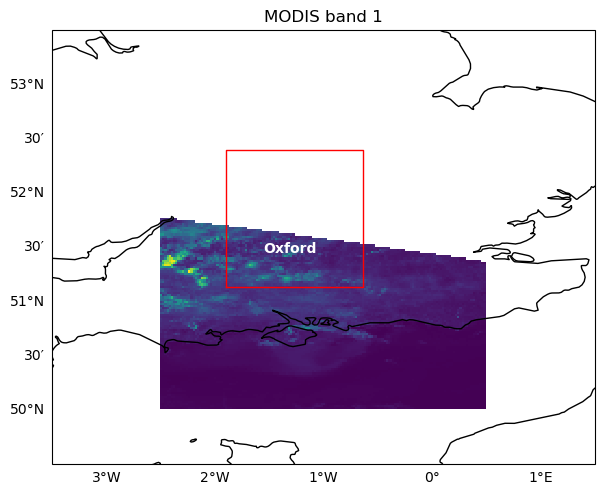

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


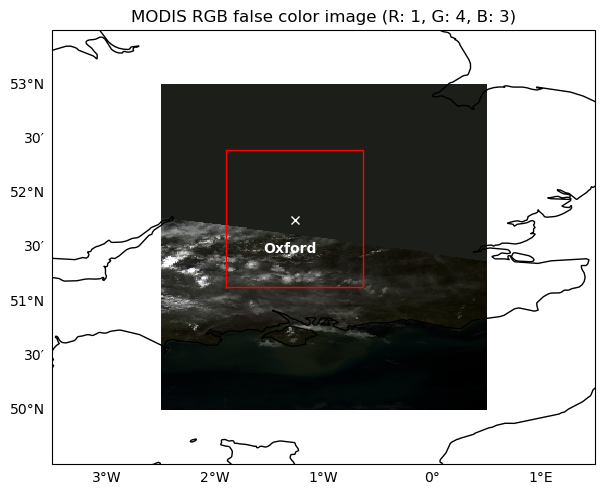

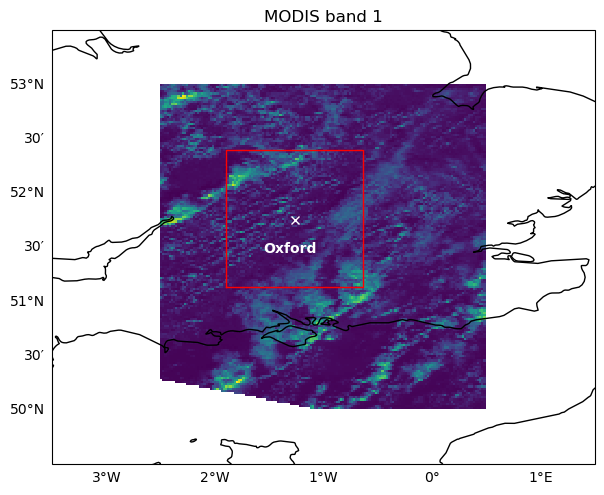

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


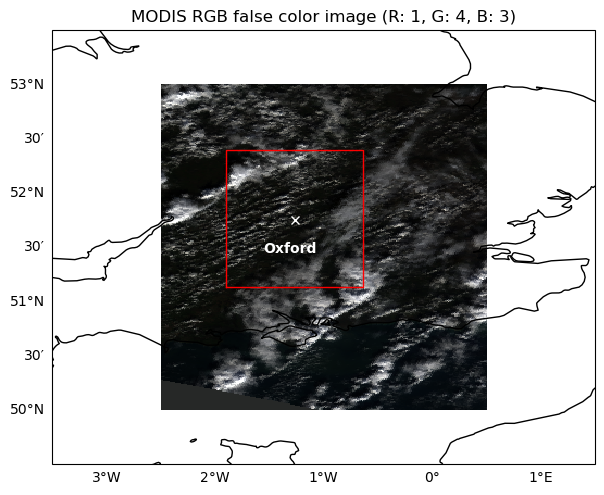

In [10]:
plot_single_channel(xr.load_dataset(modis_image_files[100]))
plot_rgb_false_color(xr.load_dataset(modis_image_files[100]))

plot_single_channel(xr.load_dataset(modis_image_files[300]))
plot_rgb_false_color(xr.load_dataset(modis_image_files[300]))

### 3. Baseline
It's always a good idea to build a very simple model for the task we're trying to solve to get a performance baseline that we can compare more elaborate ML approaches to. For our baseline, we won't use MODIS images yet but explore how well a simple ML model - a Random Forest - can predict the amount of sun each afternoon (between 1 and 8:59pm) using the amount of sun each afternoon of the previous 3 days as input. This exercise enables us to think through a few crucial choices we need to make when developing our ML pipeline.

#### 3.1. Training and Test Dataset
First, we need to split our dataset into a training, validation and test set.

**Question:** How should we split our inputs? One option would be to use January to October for training our model, and to set aside November and December for validation and testing, respectively. Another option would be to use every other month for training, and split the other months into validation and test months. Will our choice affect model performance? Why (not)? Could we just create our input (preceding 3 days of sun observation) and output (amount of sun between 3 and 4pm) matrices and randomly choose 80% of entries for training and 20% for testing?

In [11]:
ML_READY = DATA_PATH / 'ml-ready'

if not ML_READY.exists():
    with tempfile.NamedTemporaryFile() as tmp:
        print("Downloading https://zenodo.org/records/14203536/files/ml-ready.zip")
        urllib.request.urlretrieve(
            "https://zenodo.org/records/14203536/files/ml-ready.zip", tmp.name
        )
        print("Extracting ml-ready.zip")
        with zipfile.ZipFile(tmp, 'r') as zip_ref:
            zip_ref.extractall(DATA_PATH)
    
    assert ML_READY.exists(), "Download failed!"
    

In [12]:
STATION_PATH = ML_READY / 'weatherstation'
# read the dataframes
X_train_df = pd.read_csv(f'{STATION_PATH}/train_df.csv')
X_val_df = pd.read_csv(f'{STATION_PATH}/val_df.csv')
X_test_df = pd.read_csv(f'{STATION_PATH}/test_df.csv')

# read the target values
y_train_df = pd.read_csv(f'{STATION_PATH}/y_train_df.csv')
y_val_df = pd.read_csv(f'{STATION_PATH}/y_val_df.csv')
y_test_df = pd.read_csv(f'{STATION_PATH}/y_test_df.csv')


Below, you can see the variables that were included in the input features (`X_..._df`) and target values (`y_..._df`). Variables measured a day before the target date are denoted as `var_i-1`, two days before is `var_i-2` and so on.

In [13]:
print('columns in X_..._df:')
print(X_train_df.keys().to_numpy())

print('\ncolumns in y_..._df:')
print(y_train_df.keys().to_numpy())

columns in X_..._df:
['date' 'total_sun_1to8pm_i-3' 'total_sun_1to8pm_i-2'
 'total_sun_1to8pm_i-1' 'total_sun_per_day_i-3' 'total_sun_per_day_i-2'
 'total_sun_per_day_i-1' 'mean_wind_per_day_i-3' 'mean_wind_per_day_i-2'
 'mean_wind_per_day_i-1' 'mean_wind_direction_per_day_i-3'
 'mean_wind_direction_per_day_i-2' 'mean_wind_direction_per_day_i-1'
 'mean_temperature_per_day_i-3' 'mean_temperature_per_day_i-2'
 'mean_temperature_per_day_i-1' 'mean_rain_per_day_i-3'
 'mean_rain_per_day_i-2' 'mean_rain_per_day_i-1'
 'mean_pressure_per_day_i-3' 'mean_pressure_per_day_i-2'
 'mean_pressure_per_day_i-1']

columns in y_..._df:
['date' 'total_sun_1to8pm']


For now, we only use the previous days of afternoon sun measurements as our input features:

In [14]:
# select the previous 3 days of afternoon sun measurements
columns = [c for c in X_train_df.keys() if c.startswith('total_sun_1to8pm')]

# convert the dataframes into numpy arrays for sklearn models
X_train = X_train_df[columns].values
X_val = X_val_df[columns].values
X_test = X_test_df[columns].values

y_train = y_train_df['total_sun_1to8pm'].values
y_val = y_val_df['total_sun_1to8pm'].values
y_test = y_test_df['total_sun_1to8pm'].values

# create list of dates for plotting
y_dates_train = [pd.to_datetime(date).date() for date in X_train_df['date'].values]
y_dates_val = [pd.to_datetime(date).date() for date in X_val_df['date'].values]
y_dates_test = [pd.to_datetime(date).date() for date in X_test_df['date'].values]

#### 3.2. Training our Random Forest
Now, it's time to train our first model! We'll use the `scikit-learn` (abbreviated as `sklearn`) implementation of a `RandomForestRegressor`, and assess model performance using mean squared error (MSE):

MSE $ = \frac{1}{n} \sum_{i=1}^{n}(Y_{i}-\hat{Y}_{i})^2$

($n = $ number of data points; $Y_{i}	=$ observed values; $\hat{Y}_{i}=$ predicted value)



In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# set the random seed for reproducibility
RANDOM_SEED = 42

# create and train the model
model = RandomForestRegressor(random_state=RANDOM_SEED)

# train the model using input features and targets
model.fit(X_train, y_train)

# make predictions on training and validation inputs
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# calculate the mean squared error
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_val = root_mean_squared_error(y_val, y_pred_val)

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Validation RMSE: {rmse_val:.4f}')

Training RMSE: 0.7293
Validation RMSE: 1.7471


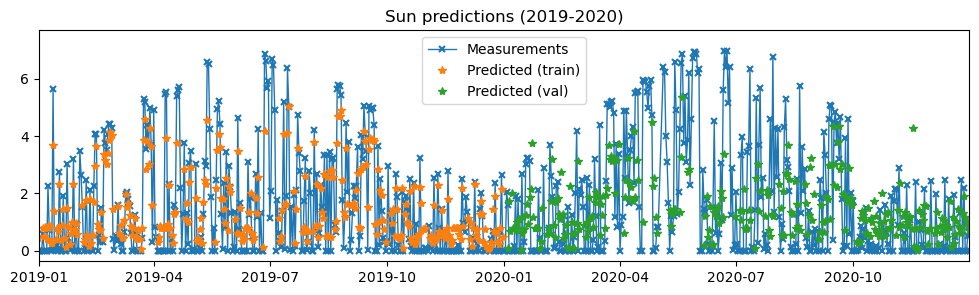

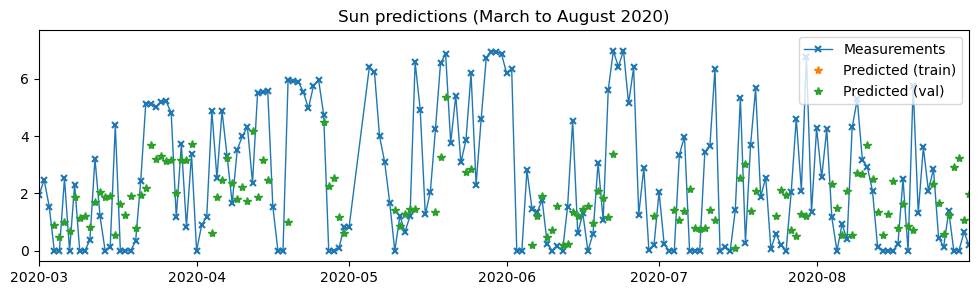

In [16]:
# helper function to plot the time series predictions
def plot_time_series_predictions(
        y_true, 
        y_dates, 
        y_pred_train,
        y_pred_val, 
        y_dates_train, 
        y_dates_val,
        xlim=(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-03-01'))
    ):
    plt.figure(figsize=(12, 3))
    plt.plot(y_dates,
            y_true,
            '-x',
            label='Measurements',
            linewidth=1,
            markersize=4,
            markeredgewidth=1.5,)

    plt.plot(y_dates_train, y_pred_train, '*', label='Predicted (train)')
    plt.plot(y_dates_val, y_pred_val, '*', label='Predicted (val)')
    plt.xlim(xlim)
    plt.legend()


all_measurements = weather_station['total_sun_1to8pm'].to_numpy()
all_measurements[(all_measurements > 8) | (all_measurements < 0)] = np.nan

plot_time_series_predictions(
    y_true=all_measurements[3:],
    y_dates=weather_station['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_dates_train=y_dates_train,
    y_dates_val=y_dates_val,
    xlim=(pd.Timestamp('2019-01-01'), pd.Timestamp('2020-12-31'))
)

plt.title('Sun predictions (2019-2020)')
plt.show()

plot_time_series_predictions(
    y_true=all_measurements[3:],
    y_dates=weather_station['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_dates_train=y_dates_train,
    y_dates_val=y_dates_val,
    xlim=(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-08-31'))
)

plt.title('Sun predictions (March to August 2020)')
plt.show()

#### 3.3. Metrics

Our first model has an RMSE of 0.73 sun-hours on the training set, and 1.75 sun-hours on the validation set. Is this good? How much skill does the model need to have to achieve these scores? We can't answer this question using RMSE alone. To get further insights, we plot the actual vs. predicted values in a scatterplot, and compute the R^2 Score on the training and validation datasets.

**Question:** How well do predictions follow the observed values? What do you notice about the predictions of the RandomForest?

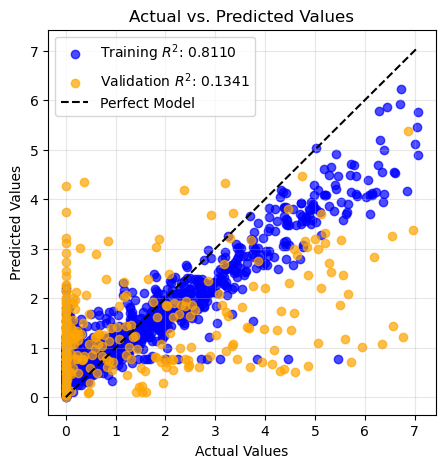

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# calculate the R^2 score on the true and predicted targets
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred_train, color='blue', label=rf'Training $R^2$: {r2_train:.4f}', alpha=0.7)
plt.scatter(y_val, y_pred_val, color='orange', label=rf'Validation $R^2$: {r2_val:.4f}', alpha=0.7)

# reference line (y = x)
max_val = max(max(y_train), max(y_val), max(y_pred_train), max(y_pred_val))
min_val = min(min(y_train), min(y_val), min(y_pred_train), min(y_pred_val))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='Perfect Model')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### 3.4. Overfitting
**Question:** The Random Forest seems to be overfitting to the training dataset (how do we know this?). We don't expect great model performance, but this seems quite severe. Read the documentation of the [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Are there any parameters which could improve this issue? Choose 1 or 2 hyperparameters and test whether you can improve validation performance by changing its value.

In [18]:
# hyperparameters -- change the values of some of the model's hyperparameters
hparams = {
    'max_depth': 5,
}

# create and train the model
model = RandomForestRegressor(**hparams, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# make predictions on training and validation inputs
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# calculate the mean squared error
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_val = root_mean_squared_error(y_val, y_pred_val)

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Validation RMSE: {rmse_val:.4f}')

Training RMSE: 1.4594
Validation RMSE: 1.6775


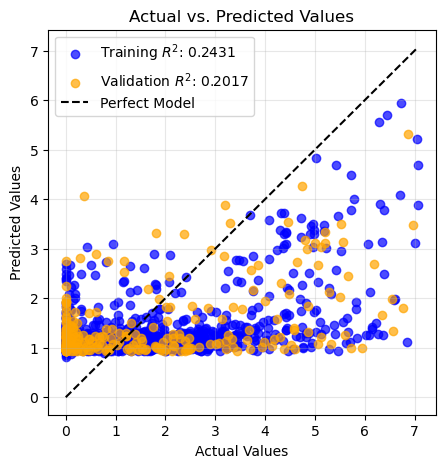

In [19]:
# calculate the R^2 score
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)


plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_pred_train, color='blue', label=rf'Training $R^2$: {r2_train:.4f}', alpha=0.7)
plt.scatter(y_val, y_pred_val, color='orange', label=rf'Validation $R^2$: {r2_val:.4f}', alpha=0.7)

# Reference line (y = x)
max_val = max(max(y_train), max(y_val), max(y_pred_train), max(y_pred_val))
min_val = min(min(y_train), min(y_val), min(y_pred_train), min(y_pred_val))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='Perfect Model')

# Plot formatting
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

As we can see, our baseline still shows poor predictive skill on the validation set, and is far from being a perfect model. Let's try and improve predictions by exploiting our satellite dataset.

### 4. Model Development
Now that we've explored our data and trained a first baseline model, we will develop our `pytorch lightning` (https://lightning.ai/docs/pytorch/stable/) training pipeline that integrates MODIS observations. Our pipeline will consist of a dataloader, model, trainer, and evaluation metrics. As you will see, the pipeline is designed in a modular way. This enables flexible experimentation, as you can easily replace the model used as an example with a model of your choice, adapt the datasets to use other inputs, ...


#### 4.1. Dataset and Dataloader
Creating our own dataset and dataloader ensures that our data is correctly normalised, formatted, etc. so it can be passed to the lightning model. These custom components also enable efficient batching and shuffling, and optimize training.

In [20]:
import numpy as np
import torch
from torch.utils.data import Dataset
from datetime import datetime

# helper function to extract the date from a MODIS filename
def get_date_from_modis_filename(filename: str) -> datetime:
    return datetime.strptime(filename.split("/")[-1][9:22], "A%Y%j.%H%M")

class SunnyOxfordDataset(Dataset):   
    # helper function to match a MODIS image with an AOPP observation
    def _match_aopp_observation(self, modis_filename: str) -> dict:
        modis_date = get_date_from_modis_filename(modis_filename)
        aopp_row = self.aopp_dataframe[self.aopp_dataframe["date"].dt.date == modis_date.date()]
        if len(aopp_row) == 0:
            print(f"No AOPP observation found for {modis_date}")
            return None
        else:
            return aopp_row.to_dict(orient="records")[0]
        
    def __init__(
        self,
        modis_filenames: list[str],
        aopp_dataframe: pd.DataFrame,
        station_inputs: list[str],
        bands: list[str] = ['1'],
        norm_params: pd.DataFrame | None = None,
        target_minmax: tuple[float] = (0, 8) # sun1to8pm is between 0 and 8
    ):
        self.modis_filenames = modis_filenames
        self.aopp_dataframe = aopp_dataframe
        self.station_inputs = station_inputs
        self.bands = bands
        if norm_params is not None:
            self.norm_params = norm_params

        self.target_minmax = target_minmax


    def __getitem__(self, ind) -> np.ndarray:
        item = {}
        ds = xr.load_dataset(self.modis_filenames[ind])

        # reduce the resolution of the image by taking every second pixel and crop to 64x64 pixels
        ds = ds.isel(x=slice(60,188,2), y=slice(60,188,2))


        # select the bands to keep
        x = np.array([ds[band].values for band in self.bands])

        # normalise each band of the input image
        if self.norm_params is not None:
            for i, band in enumerate(self.bands):
                band_mean = self.norm_params[self.norm_params['band'] == band]['mean'].values[0]
                band_std = self.norm_params[self.norm_params['band'] == band]['std'].values[0]
                x[i, :, :] = (x[i, :, :] - band_mean) / band_std

        # fill NaN values in each band with the mean of the non-NaN values of that band
        for i in range(x.shape[0]):
            if np.isnan(np.nanmean(x[i, :, :])):
                print(f'all nan for file {self.modis_filenames[ind]}')
            x[i, :, :] = np.nan_to_num(x[i, :, :], nan=np.nanmean(x[i, :, :]))

        # convert to tensor
        x = torch.as_tensor(x, dtype=torch.float32)

        item["modis_image"] = x
        
        for key, value in self._match_aopp_observation(self.modis_filenames[ind]).items():
            if key in self.station_inputs:
                value = np.array(value)
                value_scaled = (value - self.target_minmax[0]) / (self.target_minmax[1] - self.target_minmax[0])
                item[key] = torch.as_tensor(value_scaled, dtype=torch.float32)

        return item

    def __len__(self):
        return len(self.modis_filenames)

In [21]:
from lightning import LightningDataModule
from torch.utils.data import DataLoader

class SunnyOxfordDatamodule(LightningDataModule):
    def _split_modis_files(self, modis_filenames: list[str], years: list[int]) -> list[str]:
        return [f for f in modis_filenames if get_date_from_modis_filename(f).year in years]

    def __init__(
        self,
        modis_filenames: list[str],
        split_years: dict,
        station_df: pd.DataFrame,
        bands: list[str] = ['1'],
        station_inputs: list[str] = ['total_sun_1to8pm'],
        batch_size: int = 4,
        normalisation_file: str = None,
        num_workers: int = 8
    
    ):
        super().__init__()

        # self.data_dir = data_dir
        self.modis_filenames = modis_filenames
        self.split_years = split_years
        self.station_df = station_df
        self.bands = bands
        self.station_inputs = station_inputs

        self.batch_size = batch_size
        self.num_workers = num_workers

        # load normalisation parameters
        self.norm_df = pd.read_csv(normalisation_file)
        self.norm_df['band'] = self.norm_df['band'].astype(str) # for matching with band names

        # split filenames based on train/test/val criteria
        train_modis_files = self._split_modis_files(self.modis_filenames, split_years['train'])
        val_modis_files = self._split_modis_files(self.modis_filenames, split_years['validation'])
        test_modis_files = self._split_modis_files(self.modis_filenames, split_years['test'])
        

        self.train_dataset = SunnyOxfordDataset(
            modis_filenames=train_modis_files,
            aopp_dataframe=self.station_df,
            bands=self.bands,
            norm_params=self.norm_df,
            station_inputs=self.station_inputs
        )

        self.val_dataset = SunnyOxfordDataset(
            modis_filenames=val_modis_files,
            aopp_dataframe=self.station_df,
            bands=self.bands,
            norm_params=self.norm_df,
            station_inputs=self.station_inputs
        )

        self.test_dataset = SunnyOxfordDataset(
            modis_filenames=test_modis_files,
            aopp_dataframe=self.station_df,
            bands=self.bands,
            norm_params=self.norm_df,
            station_inputs=self.station_inputs
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

#### 4.2. Model Architecture
Next, we define our model architecture. For now, we'll use a simple convolutional neural network.

In [22]:
import torch.nn as nn
import torch.nn.functional as F

from lightning import LightningModule

# Define the CNN model
class SimpleCNN(LightningModule):
    def __init__(self, lr=1e-3):
        super(SimpleCNN, self).__init__()
        self.lr = lr
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Flattened size after pooling
        self.fc2 = nn.Linear(256, 1)  # Single output for regression
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x, return_embeddings=False):
        # Forward pass
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        if return_embeddings:
            return x
        x = self.fc2(x)
        return x
    
    def training_step(self, batch, batch_idx):
        # Training step
        images = batch['modis_image']
        targets = batch['total_sun_1to8pm'].unsqueeze(1) # inserting a dimension for the 1D output to match the model output
        predictions = self(images)
        loss = F.mse_loss(predictions, targets)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Validation step
        images = batch['modis_image']
        targets = batch['total_sun_1to8pm'].unsqueeze(1) # inserting a dimension for the 1D output to match the model output
        predictions = self(images)
        loss = F.mse_loss(predictions, targets)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        # Optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#### 4.3. Training
It's time to train our model!

In [23]:
from lightning.pytorch import seed_everything
seed_everything(42);

Seed set to 42


In [24]:
import pandas as pd
import os

split_years = {
    'train': [2016, 2017, 2018, 2019],
    'validation' : [2020],
    'test' : [2021]
}

STATION_PATH = os.path.join(DATA_PATH, 'ml-ready', 'weatherstation')
# read the datasets
X_train_df = pd.read_csv(f'{STATION_PATH}/train_df.csv')
X_val_df = pd.read_csv(f'{STATION_PATH}/val_df.csv')
X_test_df = pd.read_csv(f'{STATION_PATH}/test_df.csv')

# read target values
y_train_df = pd.read_csv(f'{STATION_PATH}/y_train_df.csv')
y_val_df = pd.read_csv(f'{STATION_PATH}/y_val_df.csv')
y_test_df = pd.read_csv(f'{STATION_PATH}/y_test_df.csv')

# make date column datetime in y_..._dfs
y_train_df['date'] = pd.to_datetime(y_train_df['date'])
y_val_df['date'] = pd.to_datetime(y_val_df['date'])
y_test_df['date'] = pd.to_datetime(y_test_df['date'])

# concatenate the weather station 
station_df = pd.concat([y_train_df, y_val_df, y_test_df], ignore_index=True)

modis_filenames = pd.read_csv(DATA_PATH/'ml-ready'/'modis'/'valid_files_with_obs.csv')['0'].to_list()

modis_filenames = [str(DATA_PATH/"modis"/file.split("/")[-1]) for file in modis_filenames]

datamodule = SunnyOxfordDatamodule(
    modis_filenames=modis_filenames,
    split_years=split_years,
    station_df=station_df,
    bands=['1'], # for now, choose one of the available bands
    station_inputs=['total_sun_1to8pm'],
    batch_size=8,
    normalisation_file=os.path.join(DATA_PATH, 'ml-ready', 'modis', 'normalisation_params_train.csv'), 
)

In [25]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs", name="sunny-oxford")

num_epochs = 15 # a good starting point - performance continues to improve with more epochs

# initialize the trainer
trainer = Trainer(
    max_epochs=num_epochs,
    callbacks=[TQDMProgressBar(refresh_rate=10)],
    logger=logger,
    devices=1,
    accelerator='auto',
)

# initialize model and train
model = SimpleCNN(lr=1e-4)
trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-11-25 14:51:35.693880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | conv1 | Conv2d    | 320    | train
1 | conv2 | Conv2d    | 18.5 K | train
2 | conv3 | Conv2d    | 73.9 K | train
3 | fc1   | Linear    | 2.1 M  | train
4 | fc2   | Linear    | 257    | train
5 | pool  | MaxPool2d | 0      | train
--------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.761     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


#### 4.4. Validation

In [26]:
# compute validation metrics on the best model
trainer.validate(model, datamodule.val_dataloader())

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.03217839077115059
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.03217839077115059}]

In [27]:
# model in eval mode to assemble validation predictions
model.eval()

y_pred_dict = {
    'train' : [],
    'validation' : [],
    'test' : []
}

y_true_dict = {
    'train' : [],
    'validation' : [],
    'test' : []
}

datamodules = [datamodule.train_dataloader(),
               datamodule.val_dataloader(),
               datamodule.test_dataloader()]

dataset_labels = ['train', 
                  'validation',
                  'test']

with torch.no_grad():  # disable gradient calculations
    for _datamodule, _dataset in zip(datamodules, dataset_labels):
        for batch in _datamodule:
            images = batch['modis_image']
            targets = batch['total_sun_1to8pm'].cpu().numpy()
            
            # get model predictions
            predictions = model(images).squeeze().cpu().numpy()
    
            # denormalise the predictions and targets 
            # predictions = predictions * 8
            # targets = targets * 8
            
            # store the true values and predictions
            y_true_dict[_dataset].append(targets)
            y_pred_dict[_dataset].append(predictions)
    
        # convert lists to 1D numpy arrays
        y_true_dict[_dataset] = np.concatenate(y_true_dict[_dataset], axis=0)
        y_pred_dict[_dataset] = np.concatenate(y_pred_dict[_dataset], axis=0)
    
        # remove nan labels if there are any
        array1 = np.array([1, 2, np.nan, 4, 5, np.nan])
        array2 = np.array([10, 20, 30, 40, 50, 60])
        
        # find indices of NaNs in true labels and remove from true and pred labels
        nan_indices = np.isnan(y_true_dict[_dataset])
        y_true_dict[_dataset] = y_true_dict[_dataset][~nan_indices]
        y_pred_dict[_dataset] = y_pred_dict[_dataset][~nan_indices]

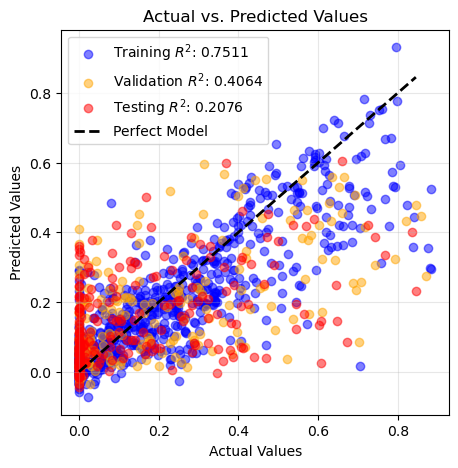

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.figure(figsize=(5, 5))

for _datamodule, _dataset, color in zip(datamodules, dataset_labels, ['blue', 'orange', 'red']):
    r2_score_dataset = r2_score(y_true_dict[_dataset], y_pred_dict[_dataset])
    l = 'Training' if 'tr' in _dataset else 'Validation' if 'val' in _dataset else 'Testing'
    plt.scatter(y_true_dict[_dataset], y_pred_dict[_dataset], color=color, label=rf'{l} $R^2$: {r2_score_dataset:.4f}', alpha=0.5)

# reference line (y = x)
plt.plot([min(y_true_dict[_dataset]), max(y_true_dict[_dataset])], [min(y_true_dict[_dataset]), max(y_true_dict[_dataset])], '--', color='black', lw=2, label='Perfect Model')

# plot formatting
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Question:** The model outperforms our simple baseline - but is this as good as it gets? The rest of this notebook contain a few suggestions for further experiments. What's the best model that you can build for this task? There seems to be some useful information contained in the simple timeseries of weather station measurements, as well as in the MODIS images. Can you think of a way to combine the two?

### 5.a. The (Feature) Importance of Environmental Inputs
In this part of the lab, you can explore whether the model benefits from receiving additional weather station measurements as input.
Can you gain some insight into how important the different inputs are for predicting sunnyness? One suggestion is to use `SHAP` (SHapley Additive exPlanations) values. SHAP values quantify the contribution of each feature to a model's prediction by distributing the prediction difference (between the actual and baseline) among the features, based on cooperative game theory. They provide an interpretable way to study feature importance.

Hints:
- A simple starting point would be to use the `RandomForestRegressor` from our baseline, but use some of the other columns available in the ML-ready station observations (i.e. in `X_train_df = pd.read_csv(f'{STATION_PATH}/train_df.csv`). Which columns have high feature importances? Is this as you would expect it to be?

### 5.b. Predictability
We have trained a model that shows promising skill in predicting sunnyness a few hours ahead. But how does model performance change when we try to predict sunnyness a day, two days, a week ahead? What would you expect, generally, and based on the autocorrelation plots from the start of the lab? If we had a perfect machine learning model, and perfect observations of all environmental variables that will affect how sunny it is -- would we be able to predict whether it will be sunny, infinitely far in the future? Why (not)?

### 5.c. Improving predictions
The two simple models, one trained on past weather station observations, one trained on MODIS satellite images, show some predictive skill - but are far from being perfect. Can you think of other ML approaches that could yield more skillful predictors, for example, by combining the different data sources that we have access to?

- The `forward` method of the `SimpleCNN` that we've trained above has a `return_embeddings` option. You could use the embeddings of the trained model, in combination with some station measurements as input to a model of your choice (could be a Random Forest, but doesn't have to be!). Does this combination of satellite image and station observations enable the model to make better predictions?